# Install packages


In [22]:
%%capture --no-stderr
!pip install -q langchain_google_genai langchain_core langchain_community tavily-python pydantic
%pip install --quiet -U langgraph psycopg2-binary

# Import packages

In [23]:
import os
import pandas as pd
from sqlalchemy import create_engine

from pydantic import BaseModel
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage

 # Set up authentication keys

In [24]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

In [25]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    api_key = GEMINI_API_KEY,
    temperature = 0)
# Test connection
print("Testing LLM connection...")
test_response = llm.invoke("Hello!")
print(f"LLM Response: {test_response.content}")

Testing LLM connection...
LLM Response: Hello! How can I help you today?


# 🛠️ Define the tools

In [26]:
# Define state
class MyState(MessagesState):
    pass

# Database tool
@tool
def get_data_from_db(query: str) -> str:
    """
    Execute SQL query on configs_strategies table and return CSV results.
    Table columns: name, symbol, time_horizon, data_exchange, use_ml, use_patterns, etc.
    """
    print(f"Executing query: {query}")

    # Get database credentials
    host = os.getenv('DB_HOST')
    user_name = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    db_name = os.getenv('DB_NAME')

    if not all([host, user_name, password, db_name]):
        return "ERROR: Database credentials not set"

    try:
        # Create SQLAlchemy engine (no warning)
        connection_string = f"postgresql://{user_name}:{password}@{host}/{db_name}"
        engine = create_engine(connection_string)

        # Execute query
        df = pd.read_sql(query, engine)
        engine.dispose()  # Clean up connection

        if df.empty:
            return "No data found"
        else:
            return df.to_csv("data.csv", index=False)

    except Exception as e:
        return f"ERROR: {str(e)}"

# Setup tools
tools = [get_data_from_db]
llm_with_tools = llm.bind_tools(tools)


In [27]:

# Node functions
def llm_node(state: MyState) -> dict:
    """Main LLM node that processes requests and calls tools"""
    print("LLM processing request...")

    # Add context about database schema
    messages = state["messages"]
    if len(messages) == 1:
        context = """You help users query a PostgreSQL database table called 'configs_strategies'.
                     Key columns: name, symbol, time_horizon, data_exchange, use_ml, use_patterns
                     Generate correct SQL queries and present results clearly."""

        enhanced_message = HumanMessage(content=f"{context}\n\nUser request: {messages[0].content}")
        messages = [enhanced_message]

    response = llm_with_tools.invoke(messages)
    return {"messages": [*state["messages"], response]}

def format_response(state: MyState) -> dict:
    """Format the final response after tool execution"""
    print("Formatting final response...")

    # Find the tool result
    messages = state["messages"]
    tool_result = None

    for msg in reversed(messages):
        if hasattr(msg, 'content') and isinstance(msg.content, str):
            if ',' in msg.content and not msg.content.startswith('ERROR'):
                tool_result = msg.content
                break

    if tool_result and not tool_result.startswith('ERROR'):
        prompt = f"The database query was successful. Here's the data:\n\n{tool_result}\n\nPlease summarize this data clearly."
    else:
        prompt = f"There was an error with the query: {tool_result}\n\nPlease explain what went wrong."

    final_response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [*state["messages"], final_response]}


Building graph...


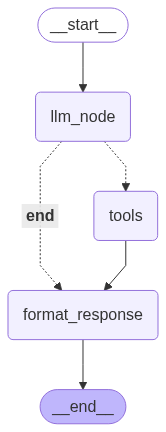

Graph built successfully


In [28]:
# Build the graph
print("Building graph...")
builder = StateGraph(MyState)

# Add nodes
builder.add_node("llm_node", llm_node)
builder.add_node("tools", ToolNode(tools))
builder.add_node("format_response", format_response)

# Add edges
builder.add_edge(START, "llm_node")
builder.add_conditional_edges(
    "llm_node",
    tools_condition,
    {
        "tools": "tools",
        "__end__": "format_response"
    }
)
builder.add_edge("tools", "format_response")
builder.add_edge("format_response", END)

# Compile graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
print("Graph built successfully")


In [32]:
def run_query(user_request):
    """Simple function to run a query"""
    print(f"\nRunning query: {user_request}")
    print("-" * 50)

    try:
        result = graph.invoke({"messages": [HumanMessage(content=user_request)]})
        final_message = result["messages"][-1]
        print("Result:")
        print(final_message.content)
        return result
    except Exception as e:
        print(f"Error: {e}")
        return None

queries = [
        "Get all rows where time_horizon = '4h'",
        "Show me 5 configurations that use ML",
        "Count strategies by time_horizon"
    ]

for query in queries:
        run_query(query)
        print("\n" + "="*60 + "\n")


Running query: Get all rows where time_horizon = '4h'
--------------------------------------------------
LLM processing request...
Executing query: SELECT * FROM configs_strategies WHERE time_horizon = '4h'
Formatting final response...
Result:
The error "There was an error with the query: None" indicates that the system received a query that was essentially empty or non-existent.  Here's a breakdown of why this is a problem and what likely happened:

* **"Query: None" means there was no actual query.** The system expected to receive some kind of instruction or request (a query), but instead, it received `None` (or its equivalent in the programming language being used).  `None` is often used to represent the absence of a value.

* **Why is this an error?**  The system is designed to process queries.  Without a query, it doesn't know what to do.  It's like asking a chef to cook something but not telling them what you want.  The system can't proceed without instructions.

* **Possible Ca